<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

此示例说明了高斯混合模型的行为适合未从高斯随机变量的混合中采样的数据。该数据集由沿着嘈杂的正弦曲线松散分布的100个点组成。因此，对于高斯分量的数量，没有真实的价值。

- 第一个模型是经典的高斯混合模型，具有10个与期望最大化算法匹配的分量。

- 第二个模型是贝叶斯高斯混合模型，该模型具有**先验Dirichlet过程**，并带有**变分推断**。先验浓度的低值使模型倾向于使用较少数量的活性成分。该模型“决定”将其建模能力集中在数据集结构的整体上：通过非对角协方差矩阵建模的具有交替方向的点组。这些交变方向大致捕获了原始正弦信号的交变性质。

- 第三个模型也是具有**Dirichlet过程先验的贝叶斯高斯混合模型**，但这次的先验浓度值较高，这给模型提供了更大的自由度来建模数据的细粒度结构。结果是混合了具有大量有效成分的混合物，这与第一个模型相似，在第一个模型中，我们任意决定将成分数固定为10。

哪个模型最好是一个主观判断的问题：我们是要偏爱那些只捕获大图来概括和解释大部分数据结构，而忽略细节的模型，还是我们更喜欢紧密遵循高密度的模型？信号的区域？

后两个面板显示了如何从后两个模型中采样。所得样本分布看起来与原始数据分布不完全相同。差异主要源于我们使用模型得出的近似误差，该模型假定数据是由有限数量的高斯分量而不是连续的噪声正弦曲线生成的。

In [1]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture

In [2]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])

In [3]:
def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

In [4]:
def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)
    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

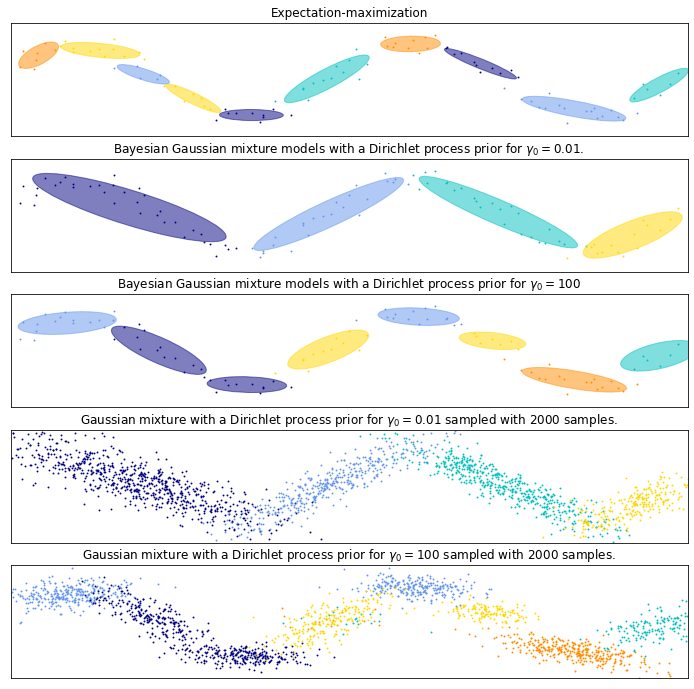

In [5]:
n_samples = 100
np.random.seed(0)
X = np.zeros((n_samples, 2))
step = 4. * np.pi / n_samples

for i in range(X.shape[0]):
    x = i * step - 6.
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3. * (np.sin(x) + np.random.normal(0, .2))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=.04, top=0.95, hspace=.2, wspace=.05,
                    left=.03, right=.97)

gmm = mixture.GaussianMixture(n_components=10, covariance_type='full',
                              max_iter=100).fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Expectation-maximization')

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(2),
    init_params="random", max_iter=100, random_state=2).fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=0.01$.")

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(X_s, y_s, dpgmm.n_components, 0,
             "Gaussian mixture with a Dirichlet process prior "
             r"for $\gamma_0=0.01$ sampled with $2000$ samples.")

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e+2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(2),
    init_params="kmeans", max_iter=100, random_state=2).fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 2,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=100$")

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(X_s, y_s, dpgmm.n_components, 1,
             "Gaussian mixture with a Dirichlet process prior "
             r"for $\gamma_0=100$ sampled with $2000$ samples.")

plt.show()